In [298]:
# Import libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read in csv for all universities
df = pd.read_csv('all_posts.csv')
df.shape

(2996, 7)

Social media tends to have a lot of memes/non-sensical discussion. For this project it would be valuable to filter out these types of posts and focus on posts that are more likely to have criticisms about the university.

# Post Level

In [299]:
# Want to see post flairs, and subsequently filter for non-shitposts
df['flair'].unique()

array(['Transfers', 'Discussion', 'Humour', 'Serious', 'News', 'Other',
       'Rant', 'Health', 'Clubs/Sports', 'Social', 'Event', 'Courses',
       'Waterloo #173', 'Academics', 'Advice', 'Confirmed', 'Meta', nan,
       'Shitpost', 'Lost & Found', 'Question', 'Politics', 'Life Advice',
       'Admissions', 'Finances', 'Programs', 'ACORN/Quercus/Outlook',
       'Free Speech', 'Waterloo #201–250', 'UTM/UTSC',
       "I'm in High School", 'Jobs', 'Photography & Art',
       'Pho(ur seasons)tography & Art', '@ SFU (Exception)', 'Megathread',
       'Congrats, you made it!', 'Photography &amp; Art',
       'Humour - Satire', 'SFU = Studying For UBC', 'Prose', '🍁',
       '100% super duper confirmed by the r/byssey', '🔥🔥🔥',
       'Ghost-type Humour', 'Unverified', 'Lost Dog', '🎉🎉🎉',
       'Read Comments Section for full context', 'Missing Person', 'F',
       'Spicy', 'HQ Post', 'Spicy Meme', 'We did it, reddit!',
       'HQ shitpost', 'Certified Dank', 'shitpost', 'Political',
       

In [300]:
# Most popular flairs
df['flair'].value_counts()[:10]

flair
Humour               961
Discussion           223
Other                159
Photography & Art    116
shitpost              73
News                  49
Academics             28
Advice                22
Courses               22
HQ Post               21
Name: count, dtype: int64

In [301]:
# Filter for popular/relevant flairs
df = df[df['flair'].isin(['Discussion', 'Other', 'News', 'Academics', 'Advice', 'Courses', 'HQ Post'])]
df.shape

(524, 7)

## Cleaning Data

In [302]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Init stopwords
stop_words = set(stopwords.words("english"))

def clean_text(df):
    '''
    This function does 3 things

    1. Combines text from title, description and comments
    2. Normalizes university names
    3. Tokenizes and lemmatizes text and removes stopwords + reddit specific words

    '''
    remove_words = ['removed', 'deleted', '[ removed by reddit ]', '[deleted]']
    # custom_stopwords = {'student', 'course', 'people', 'get', 'like', 'time', 'year', 'would'}
    # Combine text from title, description and comments
    def combine_text(text): 

        if isinstance(text, list):
            return ' '.join([word for word in text if isinstance(word, str) and word.lower() not in remove_words])
        elif isinstance(text, str): 
            # Filter out posts removed by reddit
            if re.search(r"\[?\s*removed by reddit.*?\]?", text, flags=re.IGNORECASE):
                return ''
            return text
        return ''

    
    
    # Normalize university names
    def normalize_university(text):
        # Regex to normalize uni names
        text = re.sub(r'u\sof\st', 'uoft', text)
        text = re.sub(r'university of toronto', 'uoft', text)
        text = re.sub(r'university of british columbia', 'ubc', text)
        return text

    # Tokenize + lematize + remove stopwords
    def tokenize_and_lemmatize(text): 

        # Tokenize
        tokens = word_tokenize(text)

        # Filter for strings
        words = [word for word in tokens if word.isalpha()]

        # Remove stopwords
        words = [word for word in words if word not in stop_words]
        
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in words]
    
    # Combine text
    df['combined_text'] = (df['title'].apply(combine_text).fillna('') + ' ' +
                       df['description'].apply(combine_text).fillna('') + ' ' +
                       df['comments'].apply(combine_text))

    # Lower + removing trailing charsa
    df['combined_text'] = df['combined_text'].str.lower().str.strip()
    
    # Normalize university names
    df['combined_text'] = df['combined_text'].apply(normalize_university)

    # Tokenize + lemmatize
    df['lemmatized_tokens'] = df['combined_text'].apply(tokenize_and_lemmatize)

    # Return cleaned df
    return df

df = clean_text(df)

df.head()

,date_created,title,description,comments,upvotes,flair,university,combined_text,lemmatized_tokens
1,2024-11-08 03:24:09,[ Removed by Reddit ],[ Removed by Reddit on account of violating the [content policy](/help/contentpolicy). ],"['Ik this man, he’s getting cooked. Maybe uoft won’t do anything but it’s over for him and his s...",2939,Discussion,UofT,"['ik this man, he’s getting cooked. maybe uoft won’t do anything but it’s over for him and his s...","[man, getting, cooked, maybe, uoft, anything, social, life, esp, w, apparently, deleted, twitter..."
4,2025-05-14 00:11:02,University of Toronto Faculty Association votes to divest from Israel,NaN,"['Big W, honestly im surprised', 'W faculty', 'Honestly amazing to hear!', 'Proud of my alma mat...",2163,News,UofT,"uoft faculty association votes to divest from israel ['big w, honestly im surprised', 'w facult...","[uoft, faculty, association, vote, divest, israel, w, honestly, im, surprised, w, faculty, amazi..."
5,2025-04-12 20:03:29,uoft academic offence cases are literally so entertaining,NaN,"['""The Panel does not accept this explanation as it defies common sense and logic""\n\nmeme mater...",1996,Other,UofT,"uoft academic offence cases are literally so entertaining ['""the panel does not accept this exp...","[uoft, academic, offence, case, literally, entertaining, panel, accept, explanation, defies, com..."
9,2024-11-01 19:56:49,i walked 80 kilometers and 107000 steps for 24 hours straight to mcmaster university (from utsg),posting this to show off my achievements. this walk was really painful and i’m not 100% sure it ...,['Lol I’ve done utsg to utm but all the way to McMaster is quite mental. We could’ve tried toget...,1842,Other,UofT,i walked 80 kilometers and 107000 steps for 24 hours straight to mcmaster university (from utsg)...,"[walked, kilometer, step, hour, straight, mcmaster, university, utsg, posting, show, achievement..."
13,2024-06-03 21:51:09,Just graduated at Convocation with encampment present,"Just graduated and guess what, the encampment had little to no effect on the ceremony. Cope mf’s...","[""that's so good to hear! i'm a huge supporter of the encampment, but of course wouldn't want an...",1615,Discussion,UofT,"just graduated at convocation with encampment present just graduated and guess what, the encamp...","[graduated, convocation, encampment, present, graduated, guess, encampment, little, effect, cere..."


## Investigating top k words

In [303]:
from collections import Counter

def get_topk_words(df, k):
    '''
    Takes a df and returns top k words from tokens
    '''
    all_tokens = [token for row in df['lemmatized_tokens'] for token in row]

    # Count frequencies
    token_counts = Counter(all_tokens)

    # Get top K words
    top_k = token_counts.most_common(k)

    return top_k

# Get top 10 most common words across all posts
print(f'---All Posts---\n{get_topk_words(df, 10)}')

# Get top 10 most common words across flairs
for flair in df['flair'].unique():
    print(f'---{flair}---\n{get_topk_words(df[df['flair'] == flair], 10)}')


---All Posts---
[('people', 5877), ('like', 5040), ('student', 4611), ('get', 3966), ('year', 3676), ('one', 3391), ('would', 3378), ('time', 3161), ('think', 3066), ('know', 2668)]
---Discussion---
[('people', 3817), ('like', 3058), ('student', 2560), ('get', 2262), ('would', 1921), ('one', 1875), ('year', 1851), ('think', 1815), ('time', 1560), ('know', 1559)]
---News---
[('people', 699), ('student', 545), ('like', 378), ('get', 358), ('would', 343), ('one', 328), ('think', 313), ('uoft', 269), ('know', 269), ('http', 267)]
---Other---
[('like', 749), ('people', 556), ('year', 533), ('one', 527), ('get', 517), ('student', 495), ('would', 456), ('think', 436), ('time', 433), ('uoft', 362)]
---Courses---
[('course', 336), ('student', 262), ('like', 218), ('class', 211), ('time', 149), ('one', 145), ('year', 144), ('prof', 143), ('would', 137), ('get', 133)]
---Academics---
[('student', 374), ('course', 234), ('exam', 194), ('get', 181), ('people', 172), ('like', 161), ('prof', 161), ('

It seems all posts feature words that are probably common throughout each flair.

Mutual Information (MI). If we treat our flair as a rough topic label, we can use MI to tell us information that is shared in the non-linear relationships between tokens and flairs.

### Preparing df for MI calculations

In [304]:
# 500 most common words across all universities
top_500 = get_topk_words(df, 500)

# 500 most common words for each university
uoft_df = df[df['university'] == 'UofT']
ubc_df = df[df['university'] == 'UBC']
mcgill_df = df[df['university'] == 'McGill']

uoft_500 = get_topk_words(uoft_df, 500)
ubc_500 = get_topk_words(ubc_df, 500)
mcgill_500 = get_topk_words(mcgill_df, 500)

# Convert words to bool columns for MI
def create_mi_df(df):

    # Get top k words
    top_500 = get_topk_words(df, 500)

    # Save flair column
    mi_df = df[['flair']].copy()

    # Convert words to bool columns
    binary_columns = []
    
    for word, _ in top_500:
        binary_series = df['lemmatized_tokens'].apply(lambda tokens: int(word in tokens))
        binary_series.name = word
        binary_columns.append(binary_series)

    # Concatenate all columns at once
    binary_df = pd.concat(binary_columns, axis=1)

    # Combine with the flair column
    mi_df = pd.concat([mi_df, binary_df], axis=1)

    return mi_df

# Get MI ready df for all + each university
all_mi = create_mi_df(df)
uoft_mi = create_mi_df(uoft_df)
ubc_mi = create_mi_df(ubc_df)
mcgill_mi = create_mi_df(mcgill_df)


### Making getMI function

In [305]:
from sklearn.metrics import mutual_info_score

def getMI(df, label_column = 'flair'):

    # Get list of topk words from MI df
    topk = df.select_dtypes(include = np.number).columns

    # Get label column names
    unique_labels = df[label_column].unique()

    all_scores = []

    for flair in unique_labels:
        label = (df[label_column] == flair).astype(int)

        # Get MI for topk words in flair
        for word in topk:
            score = mutual_info_score(label, df[word])
            all_scores.append({'word': word, 'mi': score, 'flair': flair})

    return pd.DataFrame(all_scores).sort_values(by='mi', ascending=False)

In [306]:
all_mi_scores = getMI(all_mi)
uoft_mi_scores = getMI(uoft_mi)
ubc_mi_scores = getMI(ubc_mi)
mcgill_mi_scores = getMI(mcgill_mi)

In [307]:
print(all_mi_scores.head(10))
print(uoft_mi_scores.head(10))
print(ubc_mi_scores.head(10))
print(mcgill_mi_scores.head(10))

        word        mi       flair
59       ubc  0.115204  Discussion
1059     ubc  0.088240       Other
1164    term  0.053971       Other
1119  reason  0.050144       Other
1169    able  0.044112       Other
7       time  0.044022  Discussion
1295   sense  0.042842       Other
1060    sure  0.040627       Other
1242  likely  0.040019       Other
1007    time  0.039811       Other
            word        mi  flair
1124      reason  0.070874  Other
1213        term  0.059766  Other
1315       sense  0.058750  Other
1106     nothing  0.058543  Other
1179        able  0.053477  Other
1270       major  0.052450  Other
1192  especially  0.052262  Other
1079    anything  0.052249  Other
1049    everyone  0.051547  Other
1061        said  0.050676  Other
          word        mi       flair
948  sometimes  0.042679        News
448  sometimes  0.042679  Discussion
818       news  0.036891        News
318       news  0.036891  Discussion
535      still  0.030140        News
35       still  0.0

Noticing that words with highest MI seem to be just the most common words... Will see what normalizing for word frequency does.

# Sentiment Analysis

In [308]:
from nltk.sentiment import SentimentIntensityAnalyzer

def evalsentences(sentences, universities, to_df = False, columns = []):
    sid = SentimentIntensityAnalyzer()
    pdlist = []

    if to_df:
        # Maintain index from original df
        for i, sentence in (sentences.items() if isinstance(sentences, pd.Series) else enumerate(sentences)):
            ss = sid.polarity_scores(sentence)
            row = [sentence, ss['compound']]
            if universities is not None:
                uni_val = universities.loc[i] if isinstance(universities, pd.Series) else universities[i]
                row.append(uni_val)
            pdlist.append((i, row))
        
        # Build into df
        df = pd.DataFrame([row for _, row in pdlist],
                          index=[idx for idx, _ in pdlist],
                          columns=columns)
        return df
    
    else:
        for sentrence in sentences:
            print('\n' + sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k], end = ''))
            print()

Text(0.5, 1.0, 'Distribution of VADER sentiment scores across posts')

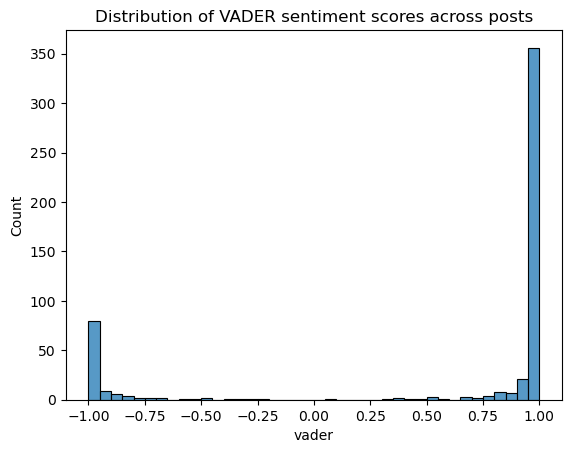

In [309]:
comments = df['combined_text']
universities = df['university']
vader_df = evalsentences(comments, universities, to_df = True, columns = ['comments', 'vader', 'university_name'])

# See distribution of sentiment across posts
sns.histplot(vader_df['vader'])
plt.title('Distribution of VADER sentiment scores across posts')

In [310]:
# Set option to show longer comments
pd.set_option('display.max_colwidth', 100)

# Add flair back in
vader_df['flair'] = df['flair']

# See what percent of comments are rated negative from VADER by flair
vader_df['is_neg'] = vader_df['vader'] < 0

percent_neg = (vader_df.groupby('flair')['is_neg']
               .mean()
               .round(2) 
               ).sort_values(ascending = False)

percent_neg

flair
News          0.45
Discussion    0.22
Academics     0.18
Other         0.18
Advice        0.14
HQ Post       0.14
Courses       0.05
Name: is_neg, dtype: float64

## PMI

In [311]:
import math
import numpy as np

def calcpmi(df, topk_words, gt_sentiment, label_column, smoothing = 1):

    # Number of observations
    n = len(df)
    label_mask = df[label_column] == gt_sentiment

    pmi_scores = []

    # Add smoothing to avoid log(0)
    px = label_mask.sum() + smoothing

    # Math for pmi
    for word, _ in topk_words:

        word_mask = df[word] == True

        py = word_mask.sum() + smoothing

        pxy = (label_mask & word_mask).sum() + smoothing

        pmi = np.log((pxy * n) / (px*py))

        pmi_scores.append((word, pmi))
    
    return pd.DataFrame(pmi_scores, columns = ['word', 'pmi']).set_index('word')
 

In [313]:
# Create pmi df
pmi_df = pd.concat([all_mi, vader_df[['is_neg', 'university_name']]], axis = 1)

# Get top pmi for words and negative sentiment across all posts
calcpmi(pmi_df, top_500, 'negative', 'is_neg').sort_values(by = 'pmi', ascending= False).head(10)

,pmi
word,
wolf,3.553441
hamas,3.553441
israel,3.371120
genocide,3.317053
pharmacy,3.317053
roommate,3.170449
indigenous,3.003395
vaccine,2.860294
wage,2.860294


### Investigating words associated with negative sentiment by flair at each uni

UofT

In [337]:
uoft_pmi = pd.concat([uoft_mi, vader_df[['is_neg', 'university_name']]], axis = 1)

for flair in uoft_pmi['flair'].unique():
    print(f'------{flair}-------')
    print(calcpmi(uoft_pmi[uoft_pmi['flair'] == flair], uoft_500, 'negative', 'is_neg').sort_values(by = 'pmi', ascending= False).head(10))

------Discussion-------
                  pmi
word                 
roommate     3.850148
genocide     3.444682
encampment   2.933857
hamas        2.933857
palestinian  2.751535
israeli      2.751535
cheating     2.597385
vaccine      2.597385
pharmacy     2.597385
israel       2.597385
------News-------
                 pmi
word                
assignment  3.555348
pharmacy    3.555348
english     3.555348
cheating    2.862201
cheat       2.862201
humanity    2.862201
stem        2.456736
c           2.456736
skill       2.456736
letter      2.456736
------Other-------
                  pmi
word                 
vaccine      4.375757
hamas        4.375757
israel       4.375757
palestinian  4.375757
encampment   4.375757
israeli      3.970292
pharmacy     3.970292
genocide     3.970292
protest      3.682610
roommate     3.682610
------Courses-------
                  pmi
word                 
genocide     3.091042
roommate     3.091042
encampment   3.091042
toronto      3.091042
israel

C:\Users\toirt\AppData\Local\Temp\ipykernel_29624\3500840323.py:24: RuntimeWarning: divide by zero encountered in log
  pmi = np.log((pxy * n) / (px*py))


In [315]:
ubc_pmi = pd.concat([ubc_mi, vader_df[['is_neg', 'university_name']]], axis = 1)

for flair in ubc_pmi['flair'].unique():
    print(f'------{flair}-------')
    print(calcpmi(ubc_pmi[ubc_pmi['flair'] == flair], ubc_500, 'negative', 'is_neg').sort_values(by = 'pmi', ascending= False).head(10))

------Discussion-------
                   pmi
word                  
tipping       3.761200
breakout      3.250374
conservative  3.250374
protest       3.068053
supremacy     2.913902
hong          2.780371
rain          2.662588
christmas     2.662588
server        2.662588
proctorio     2.557227
------News-------
                pmi
word               
server     2.639057
library    2.639057
playing    2.639057
sometimes  2.639057
privacy    2.639057
speech     2.639057
wolf       2.639057
supremacy  2.639057
hong       2.639057
trump      2.639057
------nan-------
          pmi
word         
people   -inf
line     -inf
clearly  -inf
imagine  -inf
play     -inf
employer -inf
racism   -inf
cheat    -inf
second   -inf
amount   -inf


C:\Users\toirt\AppData\Local\Temp\ipykernel_29624\3500840323.py:24: RuntimeWarning: divide by zero encountered in log
  pmi = np.log((pxy * n) / (px*py))


In [316]:
mcgill_pmi = pd.concat([mcgill_mi, vader_df[['is_neg', 'university_name']]], axis = 1)

for flair in mcgill_pmi['flair'].unique():
    print(f'------{flair}-------')
    print(calcpmi(ubc_pmi[ubc_pmi['flair'] == flair], ubc_500, 'negative', 'is_neg').sort_values(by = 'pmi', ascending= False).head(10))

------HQ Post-------
          pmi
word         
people   -inf
line     -inf
clearly  -inf
imagine  -inf
play     -inf
employer -inf
racism   -inf
cheat    -inf
second   -inf
amount   -inf
------nan-------
          pmi
word         
people   -inf
line     -inf
clearly  -inf
imagine  -inf
play     -inf
employer -inf
racism   -inf
cheat    -inf
second   -inf
amount   -inf


C:\Users\toirt\AppData\Local\Temp\ipykernel_29624\3500840323.py:24: RuntimeWarning: divide by zero encountered in log
  pmi = np.log((pxy * n) / (px*py))
C:\Users\toirt\AppData\Local\Temp\ipykernel_29624\3500840323.py:24: RuntimeWarning: divide by zero encountered in log
  pmi = np.log((pxy * n) / (px*py))


# Investigating Individual Comments

In [394]:
# Create comment df
def create_comment_df(df):    
    comment_rows = []
    # Create new comments df from posts df
    for _, row in df.iterrows():
        for comment in eval(row['comments']):
            comment_rows.append({
                'comments': comment,
                'title': row['title'],
                'date_created': row['date_created'],
                'university_name': row['university'],
                'flair': row['flair'],
                'description': row['description']
            })

    return pd.DataFrame(comment_rows)

# Clean comments 
def clean_comments(text): 
    text = str(text).lower()
    text = re.sub(r'\n', ' ', text)            # Remove newlines
    text = re.sub(r'http\S+', '', text)        # Remove links
    text = re.sub(r'[^a-z\s]', '', text)       # Remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Tokenize and lemmatize
def tokenize_and_lemmatize(text): 
        # Tokenize
        tokens = word_tokenize(text)

        # Filter for strings
        words = [word for word in tokens if word.isalpha()]

        # Remove stopwords
        words = [word for word in words if word not in stop_words]
        
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in words]

# Create comment df
comments_df = create_comment_df(df)

# Clean df
comments_df['comments'] = comments_df['comments'].apply(clean_comments)
comments_df['comments'] = comments_df['comments'].str.strip()
comments_df = comments_df[~comments_df['comments'].isin(['deleted', 'removed', ''])]
comments_df = comments_df.reset_index(drop=True)

# Tokenize + lemmatize
comments_df['lemmatized_tokens'] = comments_df['comments'].apply(tokenize_and_lemmatize)
comments_df.head()


,comments,title,date_created,university_name,flair,description,lemmatized_tokens
0,ik this man hes getting cooked maybe uoft wont do anything but its over for him and his social l...,[ Removed by Reddit ],2024-11-08 03:24:09,UofT,Discussion,[ Removed by Reddit on account of violating the [content policy](/help/contentpolicy). ],"[ik, man, he, getting, cooked, maybe, uoft, wont, anything, social, life, esp, w, gf]"
1,he apparently deleted his twitter account too its geniuenly over for bro,[ Removed by Reddit ],2024-11-08 03:24:09,UofT,Discussion,[ Removed by Reddit on account of violating the [content policy](/help/contentpolicy). ],"[apparently, deleted, twitter, account, geniuenly, bro]"
2,i think the worst part of this has to be the fact that he peaked top na in valorant,[ Removed by Reddit ],2024-11-08 03:24:09,UofT,Discussion,[ Removed by Reddit on account of violating the [content policy](/help/contentpolicy). ],"[think, worst, part, fact, peaked, top, na, valorant]"
3,christ is king jesus would def not approve of what youre saying buddy,[ Removed by Reddit ],2024-11-08 03:24:09,UofT,Discussion,[ Removed by Reddit on account of violating the [content policy](/help/contentpolicy). ],"[christ, king, jesus, would, def, approve, youre, saying, buddy]"
4,pretty deranged of him to say that you and he probably got that from nick fuentes who is a self ...,[ Removed by Reddit ],2024-11-08 03:24:09,UofT,Discussion,[ Removed by Reddit on account of violating the [content policy](/help/contentpolicy). ],"[pretty, deranged, say, probably, got, nick, fuentes, self, described, nazi, report, sure]"


In [395]:
# Evaluate comments using vader 
comments_vader = evalsentences(comments_df['comments'], comments_df['university_name'], to_df = True, columns = ['comments', 'vader', 'university_name'])
comments_df = pd.concat([comments_df, comments_vader['vader']], axis = 1)

# Seperate out comments by school
uoft_comments = comments_df[comments_df['university_name'] == 'UofT'].reset_index(drop=True)
ubc_comments = comments_df[comments_df['university_name'] == 'UBC'].reset_index(drop=True)
mcgill_comments = comments_df[comments_df['university_name'] == 'McGill'].reset_index(drop=True)

### Searching for comments related to common complaints/concerns at universities

In [398]:
def find_related_comments(df, keyword_col='comments', keyword='professor'):
    """
    Filters dataframe for rows where keyword appears in the specified column.
    """
    return df[df[keyword_col].str.contains(keyword, case=False, na=False)]


def label_sentiment(df, vader_col='vader', threshold=0):
    """
    Adds a binary 'is_neg' column based on vader sentiment scores.
    """
    df = df.copy()
    df['is_neg'] = df[vader_col] < threshold
    return df


def add_word_features(df, top_words, token_col='lemmatized_tokens'):
    """
    Adds one-hot encoded binary columns for each word in top_words.
    """
    for word in top_words:
        df[word] = df[token_col].apply(lambda tokens: word in tokens)
    return df


def get_pmi_for_keyword(df, keyword, top_k=500, sentiment_col='is_neg', target='negative'):
    """
    Full pipeline: filters for keyword, labels sentiment, adds word features, computes PMI.
    """
    # Step 1: Filter comments
    filtered_df = find_related_comments(df, keyword=keyword)

    # Step 2: Add sentiment labels
    filtered_df = label_sentiment(filtered_df)

    # Step 3: Get top-k words
    top_words = [word for word in get_topk_words(filtered_df, top_k)]

    # Step 4: Create MI dataframe
    mi_df = create_mi_df(filtered_df)

    # Step 5: Add sentiment labels to MI dataframe
    mi_df[sentiment_col] = filtered_df.loc[mi_df.index, sentiment_col]

    # Step 6: Compute PMI
    return calcpmi(mi_df, top_words, target, sentiment_col).sort_values(by='pmi', ascending=False).head(10)


In [405]:
get_pmi_for_keyword(uoft_comments, 'social')

,pmi
word,
merit,4.560870
south,4.560870
evil,4.560870
minute,4.560870
rigorous,4.273188
literature,4.273188
immigrant,4.273188
zionist,4.273188
shame,4.273188


In [ ]:
# comments_df.sample(n=1000, random_state=42).to_csv('labelling.csv')